In [66]:
from configs.RecursiveVPSDE.recursive_PostMeanScore_fOU_T256_H07_tl_5data import get_config as get_config_postmean
from configs.RecursiveVPSDE.recursive_fOU_T256_H07_tl_5data import get_config as get_config_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching import \
    ConditionalLSTMTSPostMeanScoreMatching
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSScoreMatching import \
    ConditionalLSTMTSScoreMatching
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion

In [67]:
config_postmean = get_config_postmean()
config_score = get_config_score()
rng = np.random.default_rng()
train_epoch = 960
N = 100
data_shape = (N, 1, 1)
device = "cpu"
assert(config_postmean.end_diff_time == config_score.end_diff_time and config_postmean.sample_eps == config_score.sample_eps and config_postmean.max_diff_steps == config_score.max_diff_steps)
diff_time_scale = torch.linspace(start=config_postmean.end_diff_time, end=config_postmean.sample_eps, steps=config_postmean.max_diff_steps)
real_time_scale = torch.linspace(start=1/config_postmean.ts_length, end=1,steps=config_postmean.ts_length)
assert(config_postmean.beta_max ==config_score.beta_max and config_postmean.beta_min == config_score.beta_min)
diffusion = VPSDEDiffusion(beta_max=config_score.beta_max, beta_min=config_score.beta_min)
assert(config_score.ts_length == config_postmean.ts_length)
ts_length = config_postmean.ts_length
max_diff_steps = config_postmean.max_diff_steps
sample_eps = config_postmean.sample_eps
assert(config_postmean.mean_rev == config_score.mean_rev)
mean_rev = config_postmean.mean_rev
ts_step = 1/ts_length

In [68]:
postMeanScoreModel = ConditionalLSTMTSPostMeanScoreMatching(*config_postmean.model_parameters)
postMeanScoreModel.load_state_dict(torch.load(config_postmean.scoreNet_trained_path + "_NEp" + str(train_epoch)))
scoreScoreModel = ConditionalLSTMTSScoreMatching(*config_score.model_parameters)
scoreScoreModel.load_state_dict(torch.load(config_score.scoreNet_trained_path + "_NEp" + str(train_epoch)))

<All keys matched successfully>

In [69]:
def single_time_sampling(config, diff_time_space, diffusion, feature, scoreModel, device, prev_path):
    x = diffusion.prior_sampling(shape=data_shape).to(device)  # Move to correct device
    scores = []
    exp_scores = []
    revSDE_paths = []
    for diff_index in tqdm(range(config.max_diff_steps)):
        tau = diff_time_space[diff_index]*torch.ones((data_shape[0],)).to(device)
        try:
            scoreModel.eval()
            with torch.no_grad():
                tau = tau * torch.ones((x.shape[0],)).to(device)
                predicted_score = scoreModel.forward(x, conditioner=feature, times=tau)
        except TypeError as e:
            scoreModel.eval()
            with torch.no_grad():
                tau = tau * torch.ones((x.shape[0],)).to(device)
                eff_times = diffusion.get_eff_times(diff_times=tau)
                eff_times = eff_times.reshape(x.shape)
                predicted_score = scoreModel.forward(x, conditioner=feature, times=tau, eff_times=eff_times)
        score, drift, diffParam = diffusion.get_conditional_reverse_diffusion(x=x,
                                                                                  predicted_score=predicted_score,
                                                                                  diff_index=torch.Tensor([int(diff_index)]).to(device),
                                                                                  max_diff_steps=config.max_diff_steps)
        if len(score.shape) == 3 and score.shape[-1] == 1:
            score = score.squeeze(-1)
        diffusion_mean2 = torch.atleast_2d(torch.exp(-diffusion.get_eff_times(diff_times=tau))).T.to(device)
        diffusion_var = 1. - diffusion_mean2
        exp_slope = -(1/((diffusion_var + diffusion_mean2 * ts_step))[0])
        exp_const = torch.sqrt(diffusion_mean2)*(ts_step)*(-config.mean_rev*prev_path.squeeze(-1))
        exp_score = exp_slope*(x.squeeze(-1)-exp_const)
        if len(exp_score) ==3 and exp_score.shape[0]==1:
            exp_score = exp_score.squeeze(-1)
        # Store the score, the expected score, and the revSDE paths
        scores.append(score)
        exp_scores.append(exp_score)
        if len(x.shape) == 3 and x.shape[-1] ==1:
            revSDE_paths.append(x.squeeze(-1))
        else:
            assert(x.shape == (data_shape[0], 1))
            revSDE_paths.append(x)
        # Now update sample
        z = torch.randn_like(drift)
        x = drift + diffParam * z
    scores = torch.flip(torch.concat(scores,dim=-1),dims=[1])
    exp_scores = torch.flip(torch.concat(exp_scores, dim=-1), dims=[1])
    revSDE_paths = torch.flip(torch.concat(revSDE_paths, dim=-1), dims=[1])
    #assert(scores.shape == (data_shape[0], config.max_diff_steps) and exp_scores.shape == (data_shape[0], config.max_diff_steps) and revSDE_paths == (data_shape[0], config.max_diff_steps))
    return x, scores, exp_scores, revSDE_paths

In [70]:
# I want to compare the score errors for the different models, so run recursive diffusion for 2 steps only, and output the different scores
def run_whole_ts_recursive_diffusion(config, initial_feature_input, diffusion, scoreModel, device, diff_time_scale, real_time_scale):
    stored_scores = []
    stored_expscores = []
    stored_revSDE_paths = []
    prev_paths = []
    samples = initial_feature_input
    T = 2 # config.ts_length
    cumsamples = initial_feature_input
    for t in (range(T)):
        prev_paths.append(cumsamples)
        print("Sampling at real time {}\n".format(t + 1))
        if t == 0:
            feature, (h, c) = scoreModel.rnn(samples, None)
        else:
            feature, (h, c) = scoreModel.rnn(samples, (h, c))
        new_samples, scores, exp_scores, revSDE_paths = single_time_sampling(config=config,diff_time_space=diff_time_scale, diffusion=diffusion, scoreModel=scoreModel, device=device, feature=feature, prev_path=samples)
        cumsamples = samples + new_samples
        samples = new_samples # But we feed latest INCREMENT to the LSTM
        stored_scores.append(scores.unsqueeze(1))
        stored_expscores.append(exp_scores.unsqueeze(1))
        stored_revSDE_paths.append(revSDE_paths.unsqueeze(1))
    stored_scores = torch.concat(stored_scores, dim=1)
    #assert(stored_scores.shape == (data_shape[0], T, config.max_diff_steps))
    stored_expscores = torch.concat(stored_expscores, dim=1)
    #assert(stored_expscores.shape == (data_shape[0], T, config.max_diff_steps))
    stored_revSDE_paths = torch.concat(stored_revSDE_paths, dim=1)
    #assert(stored_revSDE_paths.shape == (data_shape[0], T, config.max_diff_steps))
    prev_paths = torch.concat(prev_paths, dim=1).squeeze(-1)
    print((stored_scores.shape, stored_expscores.shape, stored_revSDE_paths.shape, prev_paths.shape))
    return stored_scores, stored_expscores, stored_revSDE_paths, prev_paths


In [71]:
# Experiment for postmean score model
initial_feature_input = torch.zeros(data_shape).to(device)
postMean_scores, postMean_expscores, postMean_revSDEpaths, postMean_prevPaths  = run_whole_ts_recursive_diffusion(config=config_postmean, initial_feature_input=initial_feature_input, diffusion=diffusion, scoreModel=postMeanScoreModel, device=device, diff_time_scale=diff_time_scale, real_time_scale=real_time_scale)

Sampling at real time 1



100%|██████████| 10000/10000 [01:28<00:00, 113.62it/s]


Sampling at real time 2



100%|██████████| 10000/10000 [01:30<00:00, 110.15it/s]


(torch.Size([100, 2, 10000]), torch.Size([100, 2, 10000]), torch.Size([100, 2, 10000]), torch.Size([100, 2]))


In [ ]:
# Experiment for postmean score model
initial_feature_input = torch.zeros(data_shape).to(device)
scores_scores, scores_expscores, scores_revSDEpaths, scores_prevPaths  = run_whole_ts_recursive_diffusion(config=config_score, initial_feature_input=initial_feature_input, diffusion=diffusion, scoreModel=scoreScoreModel, device=device, diff_time_scale=diff_time_scale, real_time_scale=real_time_scale)

In [108]:
def analyse_score_models(ts_length,max_diff_steps,sample_eps,diffusion,ts_step, mean_rev,scores, exp_scores, prev_paths, revSDE_paths, modeltype):
    # First plot the score errors for one of the models
    diff_time_space = np.linspace(sample_eps,1, max_diff_steps)
    score_errs = np.mean(np.power(scores-exp_scores,2), axis=0)
    print(score_errs.shape)
    assert(score_errs.shape == (ts_length, max_diff_steps))
    for t in range(ts_length):
        plt.plot(diff_time_space, score_errs[t, :], label=modeltype)
        plt.title(f"MSE Scores at real time {t+1}")
        plt.legend()
        plt.show()
        plt.close()
        plt.plot(diff_time_space, np.mean(scores[:,t, :],0), label="Estimated Scores")
        plt.title(f"Estimated Scores at real time {t+1}")
        plt.show()
        plt.close()
        plt.plot(diff_time_space, np.mean(exp_scores[:,t, :],0), label="Estimated Scores")
        plt.title(f"True Scores at real time {t+1}")
        plt.show()
        plt.close()

    # Which part of the score is the issue?
    eff_times = diffusion.get_eff_times(torch.Tensor(diff_time_space)).numpy()
    beta_taus = np.exp(-0.5*eff_times)
    beta_2_taus = np.exp(-eff_times)
    sigma_taus = 1.-beta_2_taus
    # Compute the part of the score independent of data mean
    c1 = -np.power(sigma_taus+beta_2_taus*ts_step,-1)
    exp_Xtau_score_component = c1*revSDE_paths
    # Compute the part of the score dependent only on the data mean
    c2 = -beta_taus*c1
    data_means = (ts_step*-1*mean_rev*prev_paths)[:,:,np.newaxis]
    exp_dataMean_score_component = data_means*(c2.reshape(1,1,-1))
    # Check the sum of both parts is the same as the expected scores
    for t in range(ts_length):
        Xtau_component = exp_scores[:, t, :] - exp_dataMean_score_component[:, t, :]
        dataMean_component = exp_scores[:, t,:] -exp_Xtau_score_component[:, t, :]
        plt.plot(diff_time_space, np.mean(Xtau_component,0))
        plt.title(f"Checking dataMean Independent Component agrees real time {t+1}")
        plt.show()
        plt.close()
        plt.plot(diff_time_space, np.mean(dataMean_component,0))
        plt.title(f"Checking dataMean dependent Component agrees real time {t+1}")
        plt.show()
        plt.close()
    # Now check each component of the score individually
    for t in range(ts_length):
        Xtau_component = scores[:, t, :] - exp_dataMean_score_component[:,t,:]
        plt.plot(diff_time_space[100:], np.mean(Xtau_component, 0)[100:], label="Estimated DataMean-Independent")
        plt.plot(diff_time_space[100:], np.mean(exp_Xtau_score_component[:,t,:], 0)[100:], label="True DataMean-Independent")
        plt.title(f"Checking DataMean Independent Component at time {t+1}")
        plt.legend()
        plt.show()
        plt.close()
    for t in range(ts_length):
        dataMean_component = scores[:, t, :] - exp_Xtau_score_component[:,t,:]
        plt.plot(diff_time_space[100:], np.mean(dataMean_component, 0)[100:], label="Estimated DataMean-Dependent")
        plt.plot(diff_time_space[100:], np.mean(exp_dataMean_score_component[:,t,:], 0)[100:], label="True DataMean-Dependent")
        plt.title(f"Checking DataMean Dependent Component at time {t+1}")
        plt.legend()
        plt.show()
        plt.close()
    if modeltype == "postMean":
        # Compute first the posterior mean
        data_mean_comp = (sigma_taus/(sigma_taus+beta_2_taus*ts_step))*data_means
        Xtau_comp = (beta_taus*ts_step/(sigma_taus+beta_2_taus*ts_step))*revSDE_paths
        post_mean = data_mean_comp+Xtau_comp
        # Visualise relative components across diffusion time
        for t in range(ts_length):
            plt.plot(diff_time_space, np.mean(data_mean_comp[:,t,:],0), label="DataMeanComp")
            plt.title(f"True DataMean Comp of Post Mean at real time {t+1}")
            plt.show()
            plt.close()
            plt.plot(diff_time_space, np.mean(Xtau_comp[:,t,:],0), label="XtauComp")
            plt.title(f"True Xtau Comp of Post Mean at real time {t+1}")
            plt.show()
            plt.close()
        for t in range(ts_length):
            realtime_scores = scores[:, t,:]
            realtime_Xtaus = revSDE_paths[:, t, :]
            realtime_network_evals = (-sigma_taus*realtime_scores + realtime_Xtaus)/(-beta_taus)
            realtime_post_mean = post_mean[:,t, :]
            plt.plot(diff_time_space, np.mean(realtime_network_evals,0), label="Evaluations")
            plt.plot(diff_time_space, np.mean(realtime_post_mean,0), label="True Post Mean")
            plt.title(f"Network Evaluations of Posterior Mean at real time {t+1}")
            plt.legend()
            plt.show()
            plt.close()

(2, 10000)


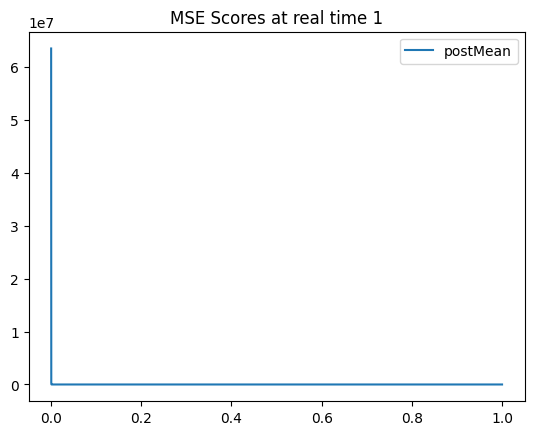

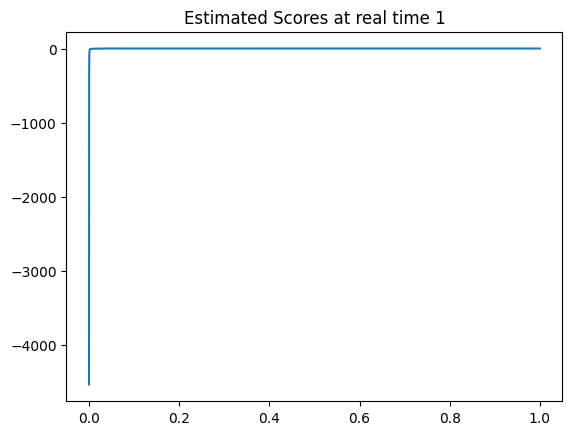

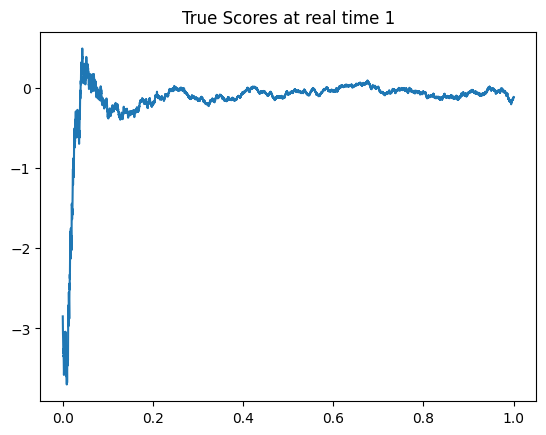

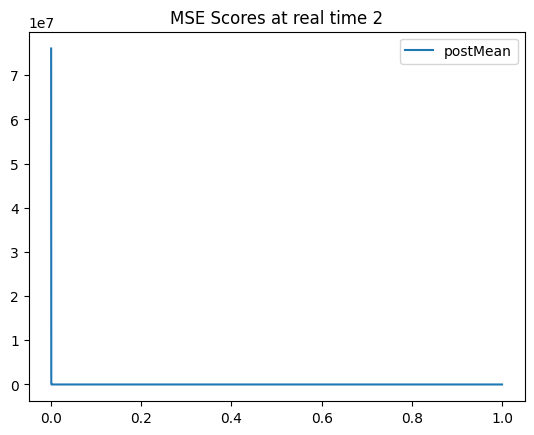

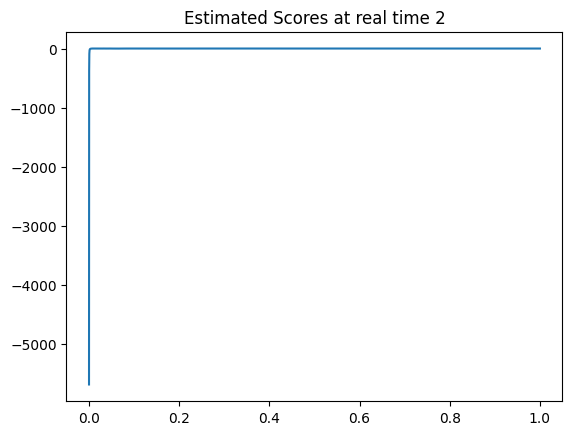

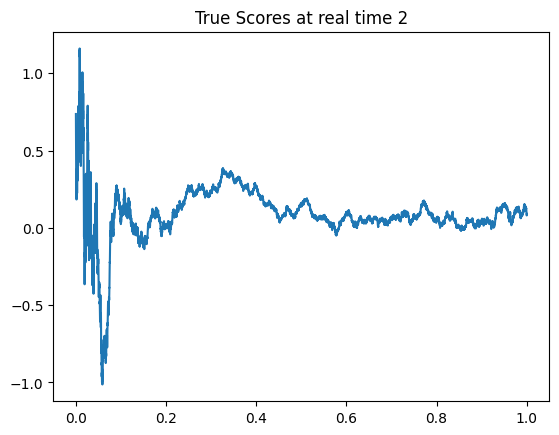

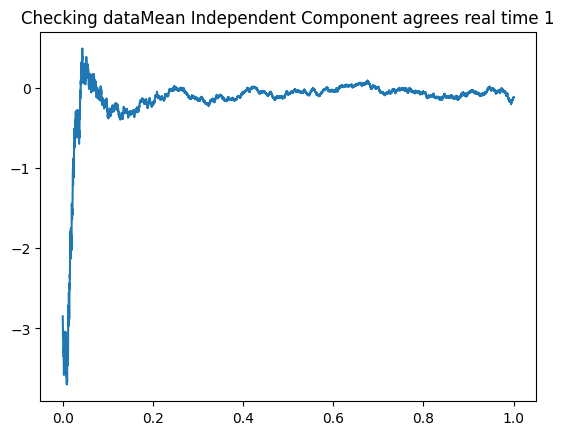

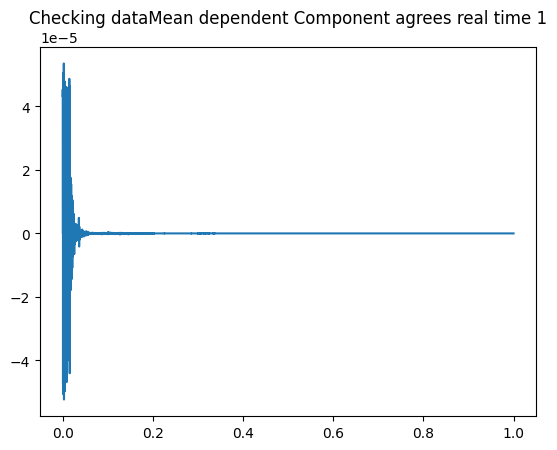

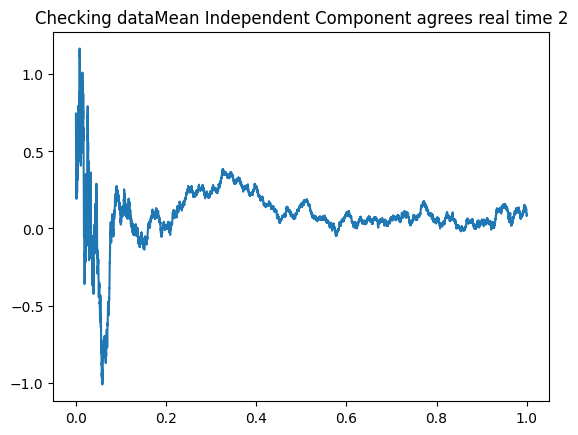

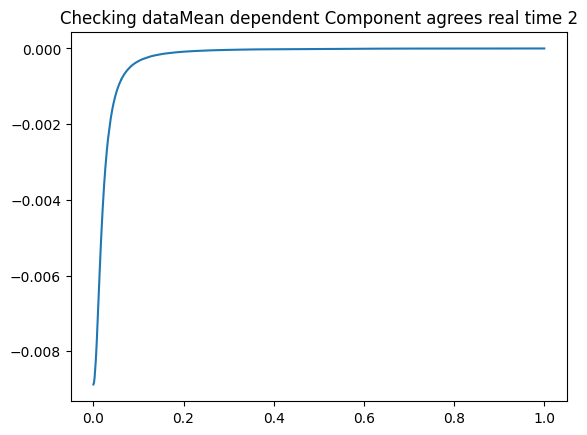

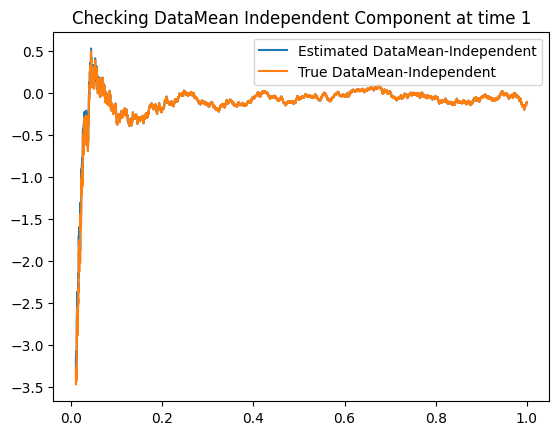

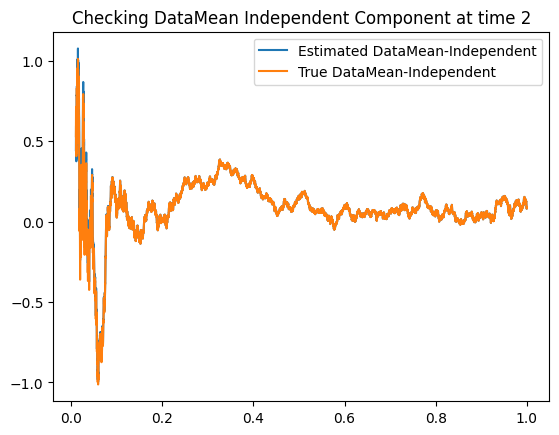

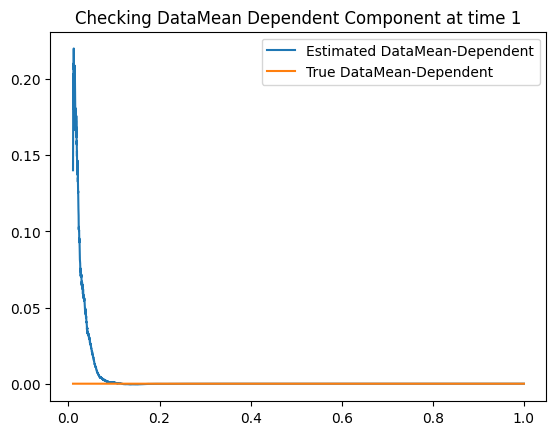

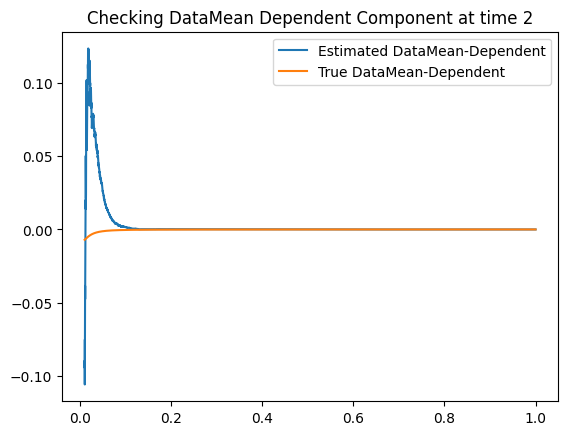

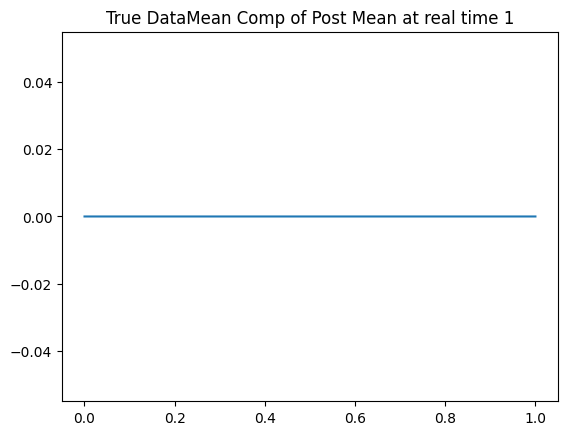

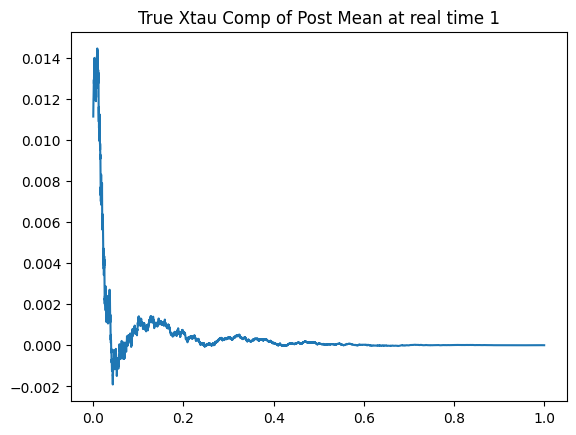

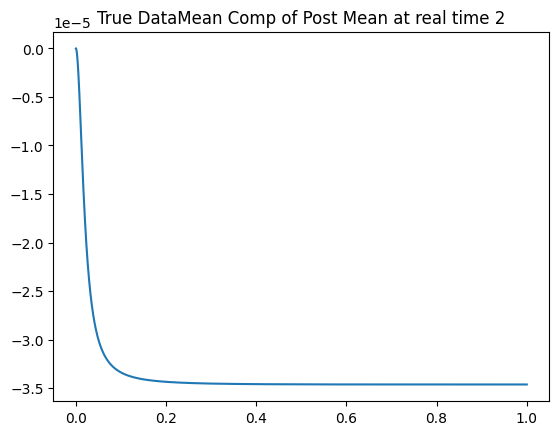

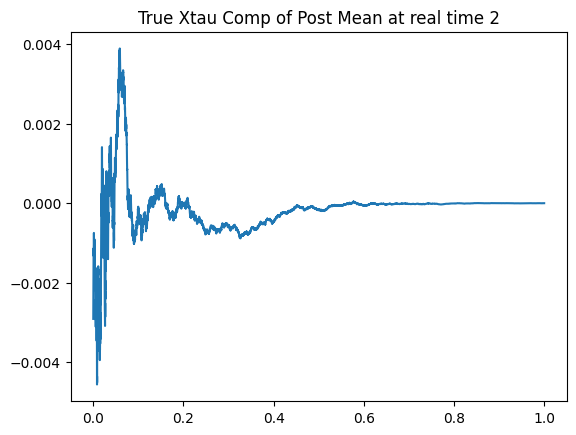

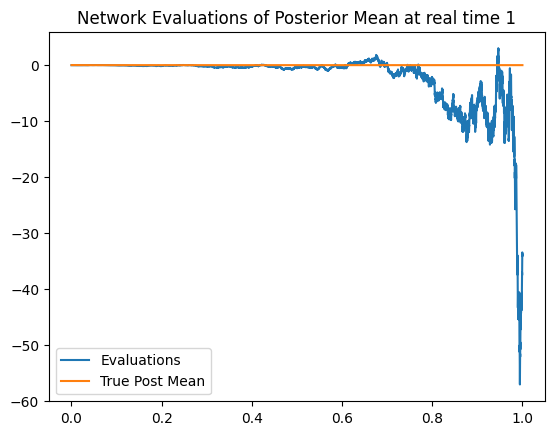

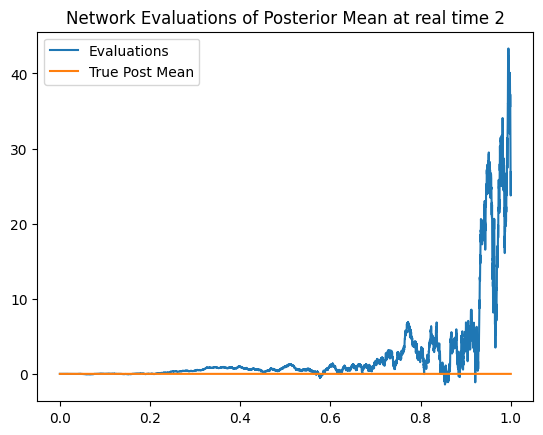

In [109]:
analyse_score_models(ts_length=2, max_diff_steps=max_diff_steps,sample_eps=sample_eps, ts_step=ts_step,mean_rev=mean_rev,diffusion=diffusion,scores=postMean_scores.numpy(), exp_scores=postMean_expscores.numpy(), revSDE_paths=postMean_revSDEpaths.numpy(), prev_paths=postMean_prevPaths.numpy(), modeltype="postMean")

(2, 10000)


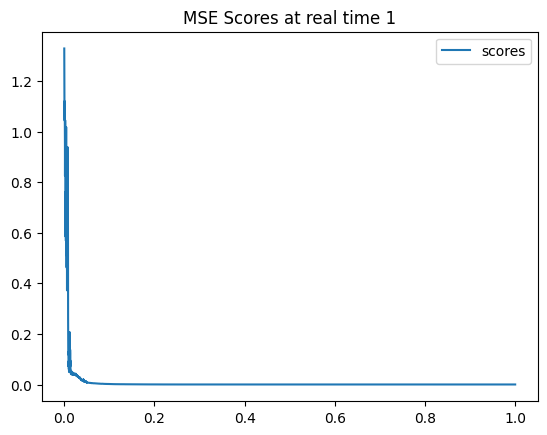

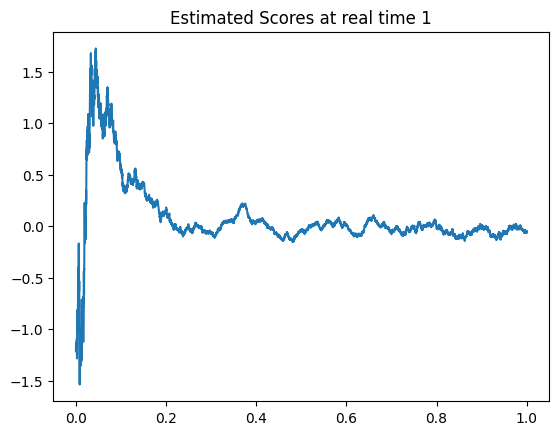

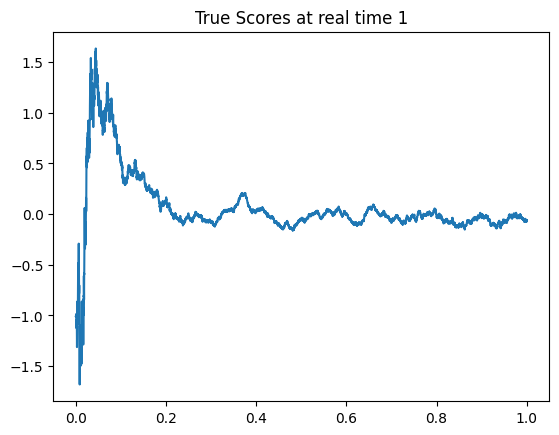

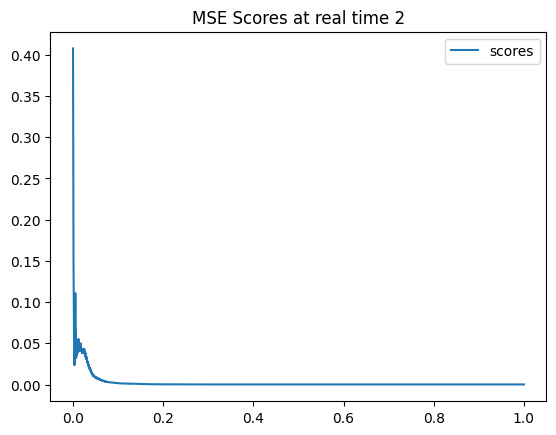

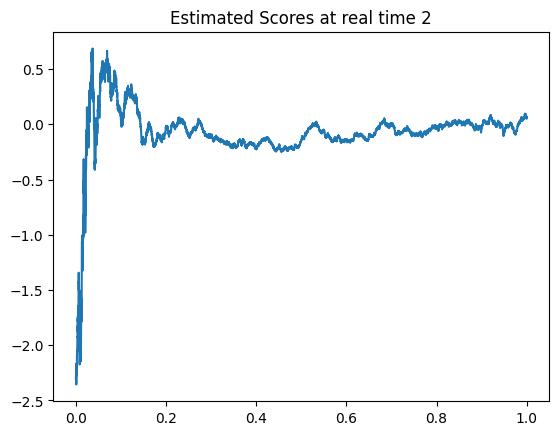

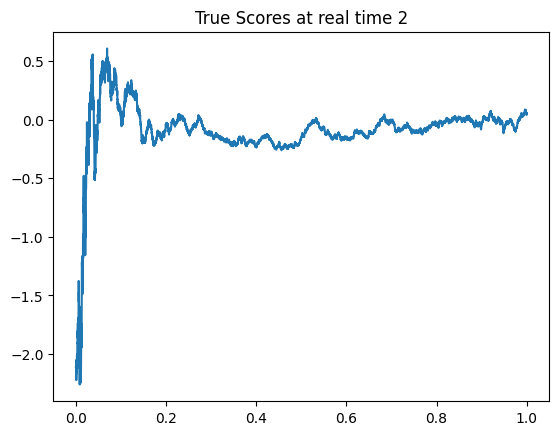

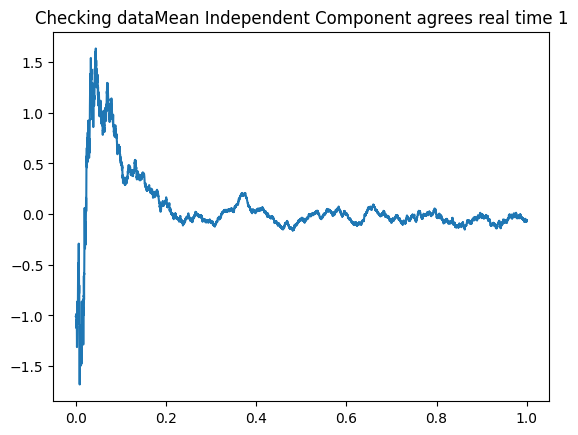

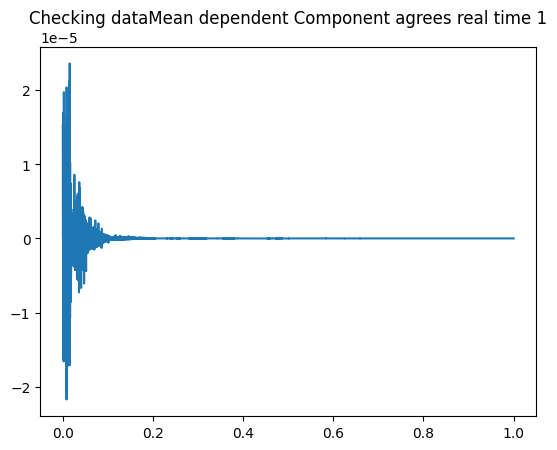

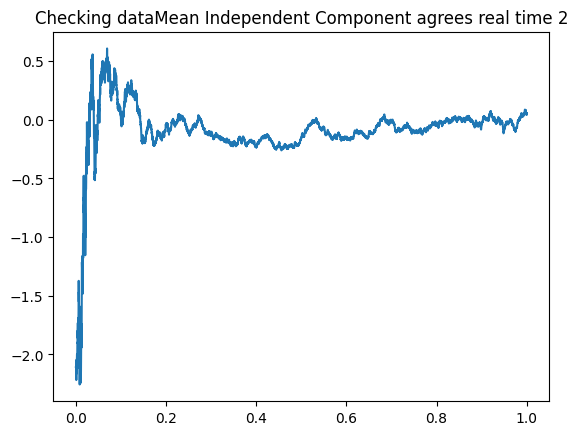

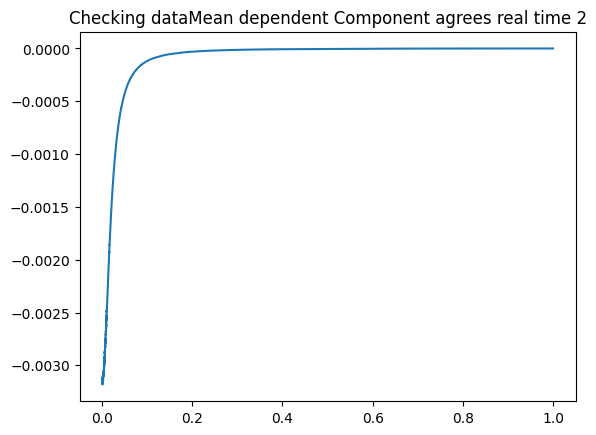

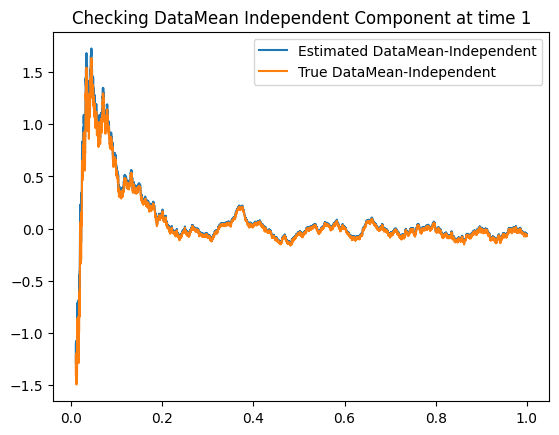

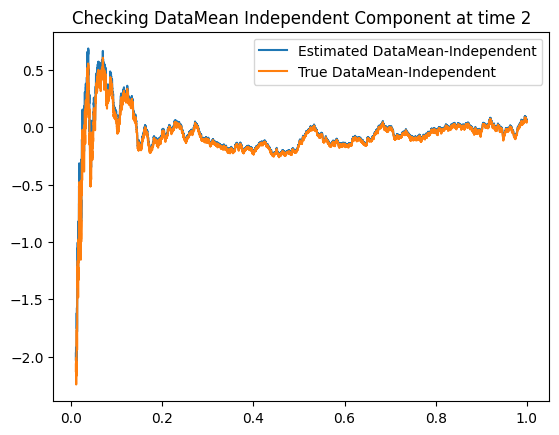

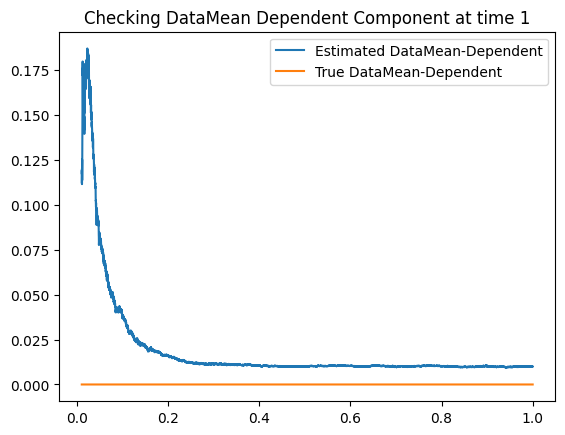

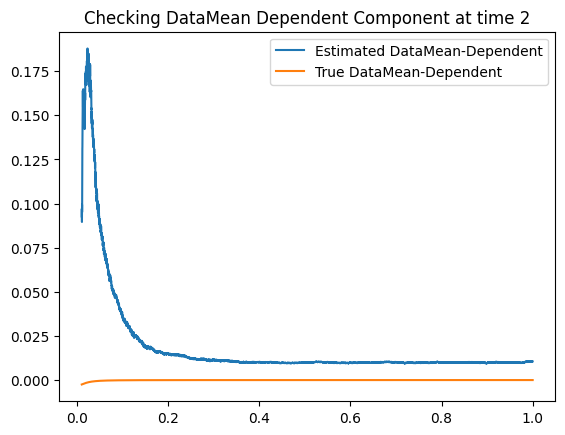

In [110]:
analyse_score_models(ts_length=2, max_diff_steps=max_diff_steps,sample_eps=sample_eps, ts_step=ts_step,mean_rev=mean_rev,diffusion=diffusion,scores=scores_scores.numpy(), exp_scores=scores_expscores.numpy(), revSDE_paths=scores_revSDEpaths.numpy(), prev_paths=scores_prevPaths.numpy(), modeltype="scores")